In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("mortality_by_latitude.csv")
print("Shape: ", df.shape)
print(df.info())
df.head()

Shape:  (16, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         16 non-null     int64  
 1   mortality_index  16 non-null     int64  
 2   temperature      16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 516.0 bytes
None


,latitude,mortality_index,temperature
0,50,1025,51.3
1,51,1045,49.9
2,52,1004,50.0
3,53,959,49.2
4,54,870,48.5


make a plot of mortality index against mean average temperature. Is it hollow up or hollow down? Try to identify a transformation of one of the variables that will straighten out the relationship, and make a plot of the residuals to check for any remaining patterns.

In [103]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df['temperature'].to_frame(), df['mortality_index'])

LinearRegression()

In [113]:
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

Slope: 23.576945334311638
Intercept: -217.94690600195963


In [201]:
temperature_range = pd.DataFrame({'temperature': np.linspace(df['temperature'].min(), df['temperature'].max(), 100)})

temperature_range['pred'] = model.predict(temperature_range[['temperature']])

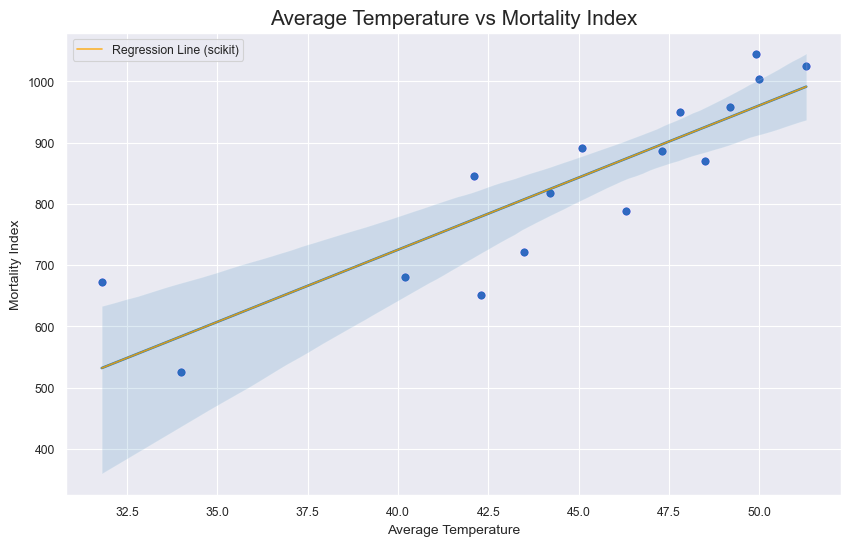

In [280]:
sns.set_context("paper")
sns.set_style("darkgrid")
fig,ax = plt.subplots(1,1, figsize=(10,6))
sns.scatterplot(df, x="temperature", y="mortality_index", ax=ax, s=40, color="#8629ff")
sns.regplot(df, x="temperature", y="mortality_index")
sns.lineplot(temperature_range, x="temperature", y="pred", label="Regression Line (scikit)", color="orange", alpha=0.8)

plt.title("Average Temperature vs Mortality Index", fontsize=15)
plt.ylabel("Mortality Index", fontsize=10)
plt.xlabel("Average Temperature", fontsize=10)
plt.legend();

In [223]:
y_pred = model.predict(df['temperature'].to_frame())
resid = df['mortality_index'] - y_pred

In [ ]:
resid

D:\tmp\ipykernel_7056\2240983477.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


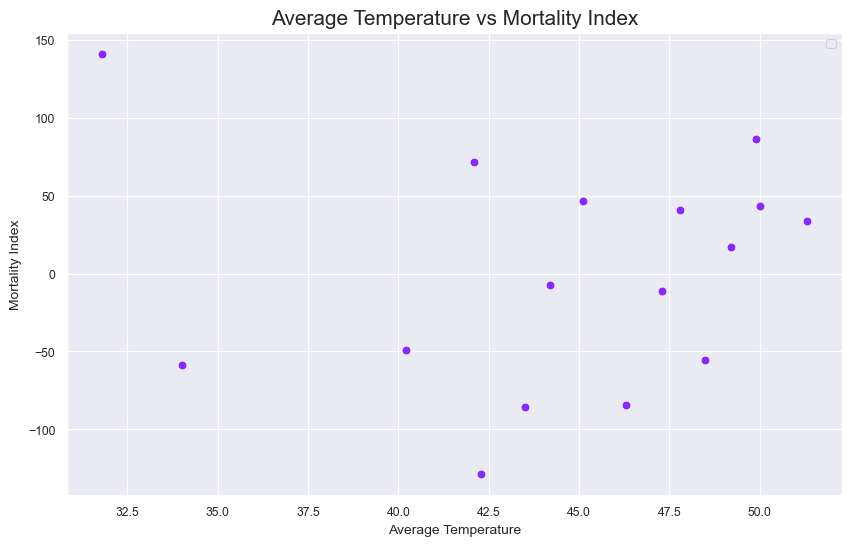

In [237]:
fig,ax = plt.subplots(1,1, figsize=(10,6))

sns.scatterplot(x=df["temperature"], y=resid, ax=ax, s=40, color="#8629ff")
# sns.regplot(df, x="temperature", y="mortality_index", label="Regression Line (sns)")
# sns.lineplot(temperature_range, x="temperature", y="pred", label="Regression Line (scikit)", color="orange", alpha=0.8)

plt.title("Average Temperature vs Mortality Index", fontsize=15)
plt.ylabel("Mortality Index", fontsize=10)
plt.xlabel("Average Temperature", fontsize=10)
plt.legend();

As we can see from the figure above, we got ourselves a pretty good linear relationship. It is also clear that the data points shows a clear upward trend, resembling a "hollow up" shape (concave up). The data `moratlity_index` seemed to accelerate as the temperature increases. For that reason, we can appply box cox transformation of negative tau to 'straighten up' the data points.

In [282]:
def box_cox(X, tau):
    if tau == 0:
        return np.log(X)
    else:
        return ((X**tau) - 1)/tau

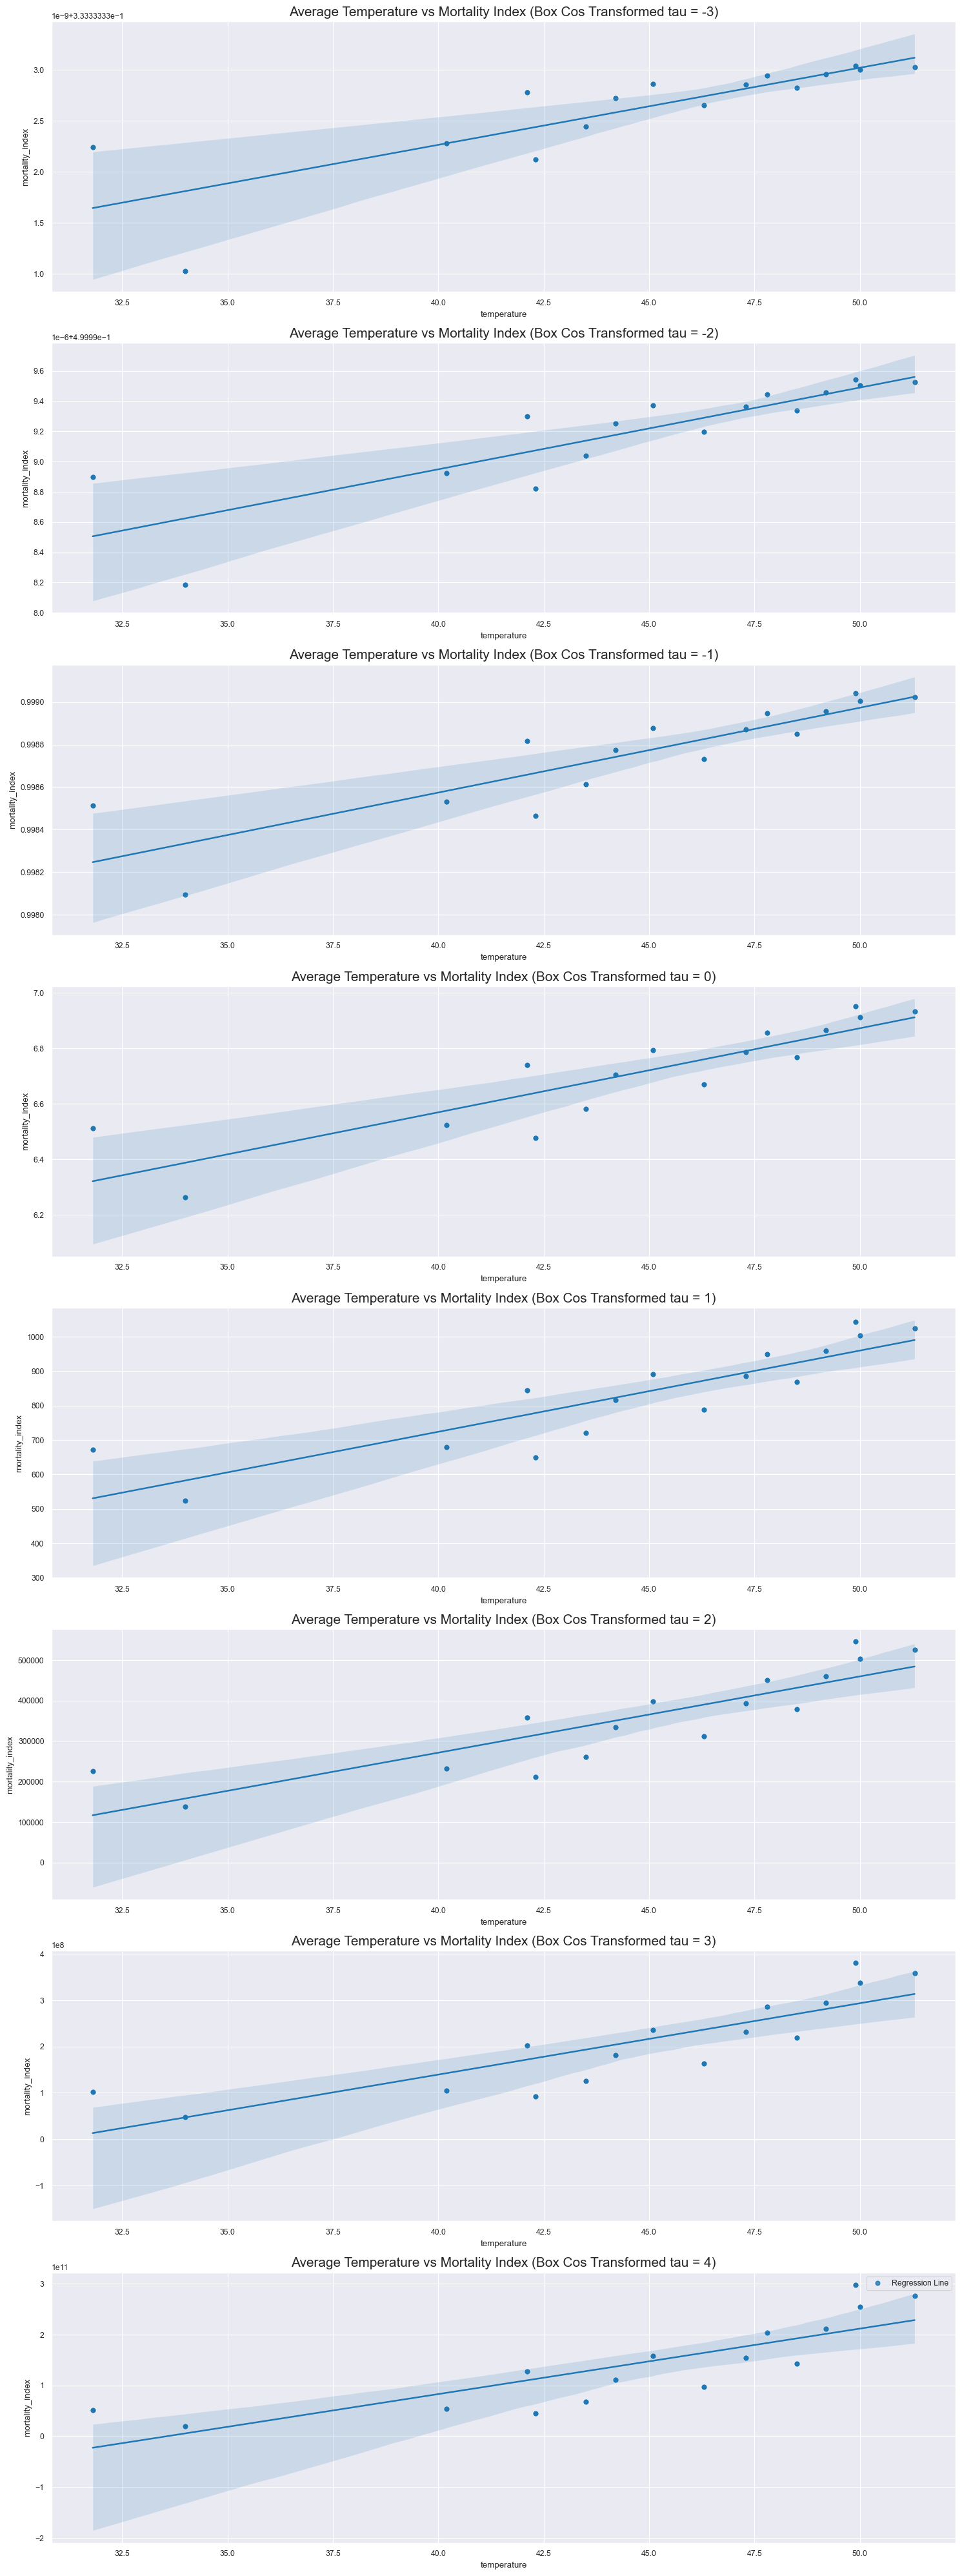

In [290]:
# log_transform = [np.log, np.log1p, np.log2]
pallete = ["#c71e48", "#9f1ec7", "#291ec7", "#641ec7"]
n=8
fig, ax = plt.subplots(ncols=1, nrows=n, figsize=(15,5*n))
ax = ax.flatten()

for i in range(n):
    box_cox_res = box_cox(df['mortality_index'].astype(float), tau=i-3)
    sns.scatterplot(x=df['temperature'], y=box_cox_res, ax=ax[i], s=40)
    sns.regplot(x=df['temperature'], y=box_cox_res, ax=ax[i], label="Regression Line")
    ax[i].set_title(f"Average Temperature vs Mortality Index (Box Cos Transformed tau = {i-3})", fontsize=15)

plt.tight_layout()
plt.legend()

In [295]:
diamonds = pd.read_csv("diamonds.csv.zip")
print("Shape: ", diamonds.shape)
print(diamonds.info())
diamonds.head()

Shape:  (53940, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB
None


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [297]:
del diamonds['Unnamed: 0']

Using the same subset of the diamonds dataset, make a plot of log price as a function of carat with a loess smoother. Try several values for the span and degree arguments and comment briefly about your choice.